# Librerias

In [1]:
# Manejo de datos
import numpy as np
import pandas as pd
import datetime

# Entrenamiento de Modelos de ML
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from mlxtend.frequent_patterns import apriori, association_rules
from scipy.sparse.linalg import svds

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import warnings

warnings.filterwarnings("ignore")

# Configuración para que al imprimir las tablas se vean completas hasta 90 columnas
pd.options.display.max_columns = 90

# Paths

In [2]:
pathClasf = "../data/processed/clasification_model_df.csv"
pathApriori = "../data/processed/apriori_model_df.csv"
pathSVD = "../data/processed/SVD_model_df.csv"

# Carga fuentes 

## Fuente Clasificacion

In [3]:
df_clas = pd.read_csv(pathClasf)

In [4]:
print(f"Dimensiones del dataframe {df_clas.shape}")
df_clas.head(5)

Dimensiones del dataframe (699601, 7)


,user_id,value_prop,prints_count,taps_count,top2_count,count_productos,label
0,98702,cellphone_recharge,1,1,1,3,0
1,98702,prepaid,1,0,1,3,1
2,98702,link_cobro,0,0,0,3,1
3,98702,credits_consumer,0,0,0,3,0
4,98702,point,0,0,0,3,1


## Fuente Apriori

In [5]:
df_apriori = pd.read_csv(pathApriori)

In [6]:
print(f"Dimensiones del dataframe {df_apriori.shape}")
df_apriori.head(5)

Dimensiones del dataframe (99943, 8)


,user_id,cellphone_recharge,credits_consumer,link_cobro,point,prepaid,send_money,transport
0,98702,0,0,1,1,1,0,0
1,63252,1,0,0,0,0,1,0
2,24728,0,0,1,0,0,1,1
3,25517,1,1,0,1,0,1,0
4,57587,1,0,1,0,0,1,1


## Fuente SVD

In [7]:
df_SVD = pd.read_csv(pathSVD)

In [8]:
print(f"Dimensiones del dataframe {df_SVD.shape}")
df_SVD.head(5)

Dimensiones del dataframe (99943, 8)


,user_id,cellphone_recharge,credits_consumer,link_cobro,point,prepaid,send_money,transport
0,1,1.650770,2.080754,3.164134,0.200000,0.100000,0.200000,2.861947
1,2,0.200000,1.642814,3.627022,3.181106,2.251297,2.475893,2.487702
2,3,2.455079,0.000000,2.881171,2.445298,3.416367,0.000000,2.593587
3,4,3.425517,1.818157,0.350000,1.206989,0.250000,2.235429,0.000000
4,5,0.000000,2.891407,1.672164,2.828512,3.385679,1.927577,0.100000


# Construccion de modelos

## Modelo Clasificacion

### Entrenamiento del modelo

In [9]:
# Preparacion de los datos

XTotal = df_clas.drop(["user_id", "value_prop", "label"], axis=1)

lista_col = XTotal.columns.tolist()
yTotal = df_clas["label"]

XTotal.shape

(699601, 4)

In [10]:
XTotal.head(5)

,prints_count,taps_count,top2_count,count_productos
0,1,1,1,3
1,1,0,1,3
2,0,0,0,3
3,0,0,0,3
4,0,0,0,3


In [11]:
XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.3, random_state=42)

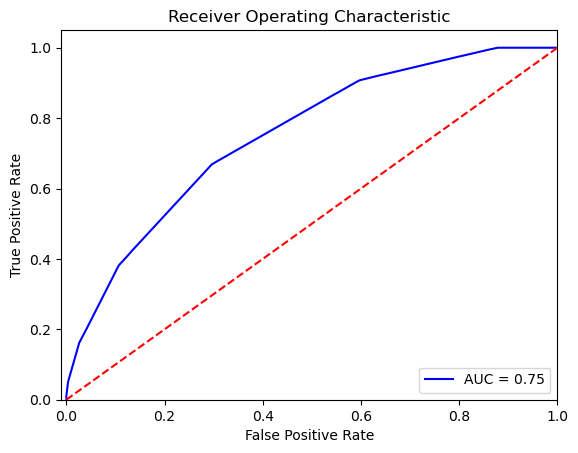

In [12]:
RF_model = RandomForestClassifier(random_state=0, class_weight="balanced")
RF_model.fit(XTrain, yTrain)

predicciones_RF_model = RF_model.predict(XTest)
prediccionesProb_RF_model = RF_model.predict_proba(XTest)

prediccionRF_model=prediccionesProb_RF_model[:,0]
fpr, tpr, thresholds = metrics.roc_curve(yTest, prediccionRF_model, pos_label=0)
AUCRF_model=metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCRF_model)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [13]:
# Matriz de confusión

cm_RF_model = confusion_matrix(yTest, predicciones_RF_model)

tp, fn, fp, tn = cm_RF_model.ravel()

print(confusion_matrix(y_true=yTest, y_pred=predicciones_RF_model))

[[46597 23154]
 [41445 98685]]


In [14]:
#Sensibilidad

sensibilidad_RF_model = tp / (tp + fn)
sensibilidad_RF_model

0.6680477699244455

In [15]:
# Accuracy

accuracyRF_modelt=accuracy_score(y_true=yTest, y_pred=predicciones_RF_model)
print(accuracyRF_modelt)

0.6922113006894383


### Exportar predicciones

Tomaremos XTest como si fuera un dataset a predecir para probar como se exportarian las predicciones del modelo

In [16]:
df_pred_clas = pd.DataFrame(prediccionesProb_RF_model[:, 1],  # probabilidad clase positiva
                               columns=["prob_clase_1"],
                               index=XTest.index)

# 2. Recuperar user_id y value_prop desde df_clas usando los índices de XTest
df_user_id = df_clas.loc[XTest.index, ["user_id", "value_prop"]]

# 3. Combinar
df_result_clas = pd.concat([df_user_id.reset_index(drop=True),
                          df_pred_clas.reset_index(drop=True)], axis=1)

# 4. Ordenar por usuario y probabilidad descendente
df_result_clas = df_result_clas.sort_values(by=["user_id", "prob_clase_1"], ascending=[True, False])

In [17]:
df_result_clas

,user_id,value_prop,prob_clase_1
12976,1,transport,0.438077
125984,1,prepaid,0.401778
94010,2,cellphone_recharge,0.759573
169075,2,point,0.751175
135415,2,transport,0.747955
...,...,...,...
175266,99999,prepaid,0.554604
118339,100000,credits_consumer,0.759573
158976,100000,point,0.751175
190934,100000,prepaid,0.751175


In [18]:
df_result_clas.to_csv("../data/output_models/recomendations_RFClas.csv")

## Modelo de recomendacion Apriori

### Generar recomendaciones

In [19]:
frequent_itemsets = apriori(
    df_apriori.drop(["user_id"], axis=1), 
    min_support=0.05,
    use_colnames=True
)

In [20]:
rules = association_rules(
    frequent_itemsets, 
    metric="lift", 
    min_threshold=1
).sort_values(by="confidence", ascending=False)

In [21]:
rules["antecedents"] = rules["antecedents"].apply(lambda x: set(x))
rules["consequents"] = rules["consequents"].apply(lambda x: set(x))

In [22]:
rules_dict = {}
for _, row in rules.iterrows():
    ant = frozenset(row["antecedents"])
    cons = row["consequents"]
    if ant not in rules_dict:
        rules_dict[ant] = []
    rules_dict[ant].append({
        "consequents": cons,
        "confidence": row["confidence"],
        "lift": row["lift"],
        "support": row["support"]
    })

In [23]:
for ant in rules_dict:
    rules_dict[ant] = sorted(rules_dict[ant], key=lambda x: x["confidence"], reverse=True)

In [24]:
def recomendar_usuario(row, top_n=4):
    """Dado un usuario, retorna lista con recomendaciones y métricas"""
    user_items = set(row.index[row == 1]) 
    resultados = []

    for ant, cons_list in rules_dict.items():
        if ant.issubset(user_items): 
            for cons_info in cons_list:
                nuevas = cons_info["consequents"] - user_items
                if nuevas:
                    resultados.append({
                        "antecedents": list(ant),
                        "consequents": list(nuevas),
                        "confidence": cons_info["confidence"],
                        "lift": cons_info["lift"],
                        "support": cons_info["support"]
                    })

    resultados = sorted(resultados, key=lambda x: x["confidence"], reverse=True)[:top_n]
    return resultados

In [25]:
df_apriori["recomendaciones"] = df_apriori.drop("user_id", axis=1).apply(recomendar_usuario, axis=1)

In [26]:
df_rec_apriori = (
    df_apriori[["user_id", "recomendaciones"]]
    .explode("recomendaciones")
    .dropna()
)

In [27]:
df_rec_apriori = pd.concat(
    [
        df_rec_apriori.drop(["recomendaciones"], axis=1),
        df_rec_apriori["recomendaciones"].apply(pd.Series)
    ],
    axis=1
)

In [28]:
df_rec_apriori.head(5)

,user_id,antecedents,consequents,confidence,lift,support
0,98702,"[point, link_cobro, prepaid]",[credits_consumer],0.708745,1.062362,0.222687
0,98702,"[point, link_cobro, prepaid]",[cellphone_recharge],0.702726,1.056398,0.220796
0,98702,"[point, link_cobro, prepaid]",[transport],0.701962,1.050588,0.220556
0,98702,"[point, link_cobro, prepaid]",[send_money],0.699955,1.047538,0.219925
1,63252,"[cellphone_recharge, send_money]",[transport],0.696559,1.042503,0.316620


### Exportar predicciones

In [29]:
df_rec_apriori.to_csv("../data/output_models/recomendations_apriori.csv")

## Modelo de recomendacion Colaborativo (SVD)

### Generar recomendaciones

In [30]:
ratings = df_SVD.drop(columns=["user_id"]).to_numpy()
user_ids = df_SVD["user_id"].values

In [31]:
user_ratings_mean = np.mean(ratings, axis=1)
R_demeaned = ratings - user_ratings_mean.reshape(-1, 1)

In [32]:
k = min(ratings.shape) - 1   # aquí = 6
U, sigma, Vt = svds(R_demeaned, k=k)
sigma = np.diag(sigma)

In [33]:
R_pred = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [34]:
cols = df_SVD.drop(columns=["user_id"]).columns
pred_df = pd.DataFrame(R_pred, columns=cols, index=user_ids)

In [35]:
def get_recommendations(pred_df, user_id, num_recommendations=5):
    user_preds = pred_df.loc[user_id].sort_values(ascending=False)
    top_items = user_preds.head(num_recommendations).index.tolist()
    top_scores = user_preds.head(num_recommendations).values.tolist()
    return top_items, top_scores

In [36]:
num_recommendations = 5
recs = []

for uid in user_ids:
    items, scores = get_recommendations(pred_df, uid, num_recommendations)
    row = {"user_id": uid}
    for i in range(num_recommendations):
        row[f"top_{i+1}"] = items[i]
        row[f"score_{i+1}"] = scores[i]
    recs.append(row)

recomendaciones_df = pd.DataFrame(recs)

In [37]:
print(recomendaciones_df.shape)
recomendaciones_df.head(5)

(99943, 11)


,user_id,top_1,score_1,top_2,score_2,top_3,score_3,top_4,score_4,top_5,score_5
0,1,link_cobro,3.164134,transport,2.861947,credits_consumer,2.080754,cellphone_recharge,1.650770,send_money,0.200000
1,2,link_cobro,3.627022,point,3.181106,transport,2.487702,send_money,2.475893,prepaid,2.251297
2,3,prepaid,3.416367,link_cobro,2.881171,transport,2.593587,cellphone_recharge,2.455079,point,2.445298
3,4,cellphone_recharge,3.425517,send_money,2.235429,credits_consumer,1.818157,point,1.206989,link_cobro,0.350000
4,5,prepaid,3.385679,credits_consumer,2.891407,point,2.828512,send_money,1.927577,link_cobro,1.672164


### Exportar predicciones

In [38]:
recomendaciones_df.to_csv("../data/output_models/recomendations_SVD.csv")